In [6]:
import torch
from torchvision import transforms
import torch.utils.data as data
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from models import *
from data_loader import get_loader

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])


def caption_list_gen(caption,batch_size):
    caption_list=[]
    for i in range(len(caption[0])):
        new_caption=[]
        for j in range(len(caption)):
            new_caption.append(caption[j][i])
        caption_list.append(new_caption)
    return caption_list


def load_model(model_path='model_13epochs_sumboth.tar',map_location='cpu'):
    image_model = VGG19(pretrained=True)
    caption_model = LSTMBranch()
    checkpoint = torch.load(model_path, map_location)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    image_model.load_state_dict(checkpoint['image_model'])
    caption_model.load_state_dict(checkpoint['caption_model'])
    print ("Loaded checkpoint '{}' (epoch {})".format(model_path,checkpoint['epoch']))
    return image_model, caption_model


def gen_matchmap(image_model, caption_model, image_tensor, caption_tensor):
    image_op = image_model(image_tensor)
    caption_op = caption_model(caption_tensor)

    n_imgs = image_op.size(0)
    matchmap_list = []

    for i in range(n_imgs):
        matchmap = matchmap_generate(image_op[i],caption_op[i])
        mm = matchmap.detach().numpy()
        matchmap_list.append(mm)

    return matchmap_list

def get_data(batch_size, fetch_mode='retrieval'):
    data_loader_val = get_loader(transform=transform,
                                  mode='val',
                                  batch_size=1,
                                  vocab_from_file=True,
                                  fetch_mode='retrieval',
                                  data_mode='image')
    imgindices = data_loader_val.dataset.get_imgindices()
    new_sampler_img = data.sampler.SubsetRandomSampler(indices=imgindices)
    data_loader_val.batch_sampler.sampler=new_sampler_img
    
    #it = iter(data_loader_val)
    #for i in range(0,5):
    #    print ("HI")
    #    image_tensor = next(it)
    #    break
    
    for batch in data_loader_val:
        image_tensor = batch
        break
    print ("SELECTED IMAGE TENSOR",image_tensor.shape)

    capindices = data_loader_val.dataset.get_capindices()

    data_loader_val_cap = get_loader(transform=transform,
                                      mode='val',
                                      batch_size=1,
                                      vocab_from_file=True,
                                      fetch_mode='retrieval',
                                      data_mode='caption')
    new_sampler_cap = data.sampler.SubsetRandomSampler(indices=capindices)
    data_loader_val_cap.batch_sampler.sampler=new_sampler_cap

    for batch in data_loader_val_cap:
        caption_glove_list,captions=batch[0],batch[1]
        break

    return image_tensor,caption_glove_list,captions

def get_output(image_tensor,image_model,caption_glove_tensor,caption_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_model = image_model.to(device)
    caption_model = caption_model.to(device)
    image_model.eval()
    caption_model.eval()
    image_ip_val = image_tensor.to(device)
    all_caption_output_val=[]
    for everytensor in caption_glove_list:
        caption_glove_ip_val = everytensor.to(device)
        caption_output_val = caption_model(caption_glove_ip_val)
        all_caption_output_val.append(caption_output_val)
    image_output_val = image_model(image_ip_val)
    print ("Created Caption Tensors")
    return image_output_val, all_caption_output_val

def get_sim_mat(image_output,caption_glove_tensor_output,score_type):
    sim_mat=[]
    for captiontensor in caption_glove_tensor_output:
        sim_val = compute_matchmap_similarity_matrix(image_output,captiontensor,score_type)
        #print ("SIM VAL",sim_val.item())
        sim_mat.append(sim_val)
    return sim_mat

Loaded checkpoint 'model_13epochs_sumboth.tar' (epoch 13)
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
The total Image IDs in Val Set are: 40504
The toal 1k Images are: 1000
The total 5k Captions are: 5004
ASDADAD Index sampled is: 904
######################## GT ##########################
['Small child in a green shirt standing inside of a suitcase. ', 'A toddler sitting in a toddler sized recliner', 'A little girl in a green shirt sitting on a chair.', 'A little girl sitting in a piece of luggage.', 'A toddler on a seat on the floor.  ']
******************** AFTER TRANSFORM **************** torch.Size([3, 224, 224]) COCO_val2014_000000042667.jpg 904
SELECTED IMAGE TENSOR torch.Size([1, 3, 224, 224])
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
The total Image IDs in Val Set are: 40504
The toal 1k Images are

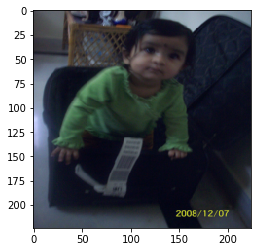

In [9]:
image_model, caption_model = load_model()
batch_size = 64
score_type = 'Avg_Both'
image_tensor,caption_glove_list,captions = get_data(batch_size)

print ("sizes of tensors",image_tensor.shape,type(caption_glove_list),len(captions),len(caption_glove_list))

img = torch.squeeze(image_tensor,0)
img = img.permute(1,2,0)
color_img = img.numpy()
color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
plt.imshow(color_img)

image_output, caption_glove_tensor_output = get_output(image_tensor,image_model,caption_glove_list,caption_model)



sim_mat = get_sim_mat(image_output,caption_glove_tensor_output,score_type)

sim_mat = torch.Tensor(sim_mat)

#print("sim mat:", sim_mat)

#C2I_scores, C2I_ind = sim_mat.topk(1,0)
I2C_scores, I2C_ind = sim_mat.topk(5,0)

for i in I2C_ind:
    print ("For Image the top caption is:" %(i))
    print (captions[i])